## Project Overview

This project explores image classification on the CIFAR-10 dataset using two fundamentally different model families:
1. Fully Connected Networks (FCNs) — a baseline approach treating images as flat vectors.
2. Convolutional Neural Networks (CNNs) — architectures that exploit spatial structure in images.

The goal is not only to achieve higher accuracy, but also to demonstrate the progression from a simple, limited baseline toward a modern, spatially-aware model, analyzing how architectural choices, regularization, optimization, and data augmentation influence performance.

In [ ]:
#to install if missing
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install matplotlib numpy pandas seaborn scikit-learn tqdm torchsummary


### Loading and Exploring the CIFAR-10 Dataset

We begin by loading the CIFAR-10 dataset, a widely used benchmark consisting of 60,000 color images of size 32×32, divided into 10 object categories.
Each image represents a small natural scene object such as airplane, cat, dog, ship, or truck.

In [52]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ['airplane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples:     {len(test_dataset)}")


100%|██████████████████████████████████████| 170M/170M [00:11<00:00, 15.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Test samples:     10000


### Content of the dataset

In [ ]:
def imshow(img_tensor):
    img = img_tensor.clone().permute(1, 2, 0).numpy()
    img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')

plt.show()


## Fully Connected Neural Network

### Baseline Model
To establish a simple baseline, we begin with a fully connected neural network trained directly on flattened 32×32×3 CIFAR-10 images.
Our baseline architecture:
* Input: 3072-dimensional vector (flattened image)
* Hidden layer 1: 100 neurons
* Hidden layer 2: 20 neurons
* Output: 10 classes
* Activation: ReLU
* Optimizer: SGD

In [4]:
class FCN(nn.Module):
    def __init__(self, input_dim=3072, hidden1=100, hidden2=20, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [54]:
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=25, device='cpu', scheduler=None):
    history = {
        "train_loss": [], "test_loss": [],
        "train_acc": [],  "test_acc": []
    }

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc  = correct / total

        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = test_correct / test_total
        if scheduler is not None:
            scheduler.step()

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} "
              f"| Test Loss: {test_loss:.4f} Acc: {test_acc:.3f}")

    return history


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

baseline_model = FCN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)

history_baseline = train_model(
    baseline_model, optimizer, criterion,
    train_loader, test_loader,
    device=device
)


Epoch 1/25 | Train Loss: 1.7107 Acc: 0.392 | Test Loss: 1.5574 Acc: 0.452
Epoch 2/25 | Train Loss: 1.5140 Acc: 0.466 | Test Loss: 1.4916 Acc: 0.478
Epoch 3/25 | Train Loss: 1.4391 Acc: 0.490 | Test Loss: 1.4384 Acc: 0.489
Epoch 4/25 | Train Loss: 1.3807 Acc: 0.513 | Test Loss: 1.4858 Acc: 0.471
Epoch 5/25 | Train Loss: 1.3447 Acc: 0.528 | Test Loss: 1.4491 Acc: 0.493
Epoch 6/25 | Train Loss: 1.3040 Acc: 0.540 | Test Loss: 1.4419 Acc: 0.492
Epoch 7/25 | Train Loss: 1.2772 Acc: 0.550 | Test Loss: 1.4482 Acc: 0.512
Epoch 8/25 | Train Loss: 1.2525 Acc: 0.557 | Test Loss: 1.4469 Acc: 0.501
Epoch 9/25 | Train Loss: 1.2239 Acc: 0.567 | Test Loss: 1.4554 Acc: 0.506
Epoch 10/25 | Train Loss: 1.2010 Acc: 0.577 | Test Loss: 1.4628 Acc: 0.500
Epoch 11/25 | Train Loss: 1.1860 Acc: 0.582 | Test Loss: 1.4853 Acc: 0.495
Epoch 12/25 | Train Loss: 1.1634 Acc: 0.591 | Test Loss: 1.4759 Acc: 0.506
Epoch 13/25 | Train Loss: 1.1416 Acc: 0.598 | Test Loss: 1.4773 Acc: 0.497
Epoch 14/25 | Train Loss: 1.1213 A

In [10]:
def plot_history(history, title_prefix="Baseline FCN"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["test_loss"], label="Validation Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], label="Validation Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()


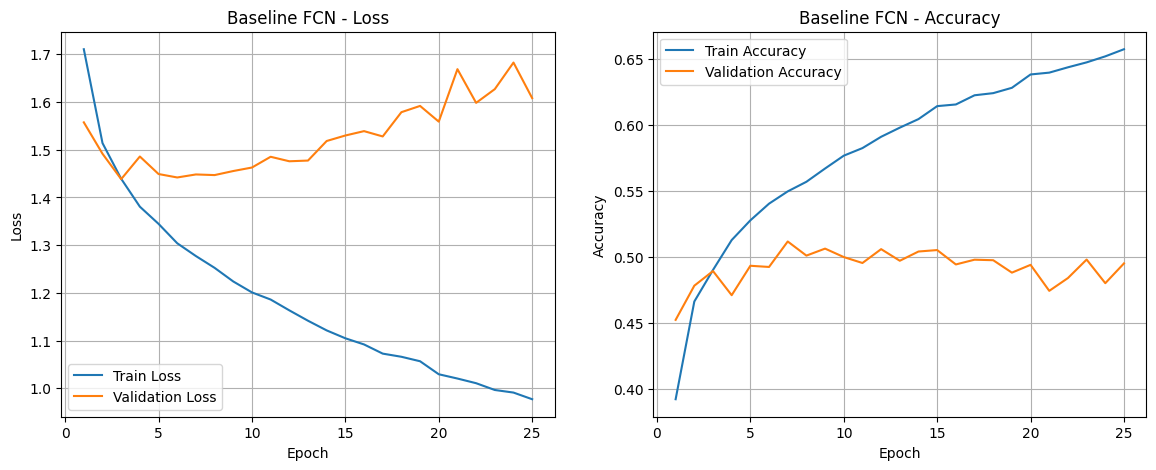

In [11]:
plot_history(history_baseline)


### Initial Conclusion
1. Training accuracy steadily improves (up to ~65.7%), so the model can learn patterns from the data when trained longer.
2. Validation accuracy plateaus early (stays around 49–51%)

This gap between training and validation performance reveals:
* the model underfits the true structure of the data
* it cannot generalize beyond what it memorizes
* the improvement in training accuracy does not translate to real performance

3. Validation loss increases toward the end => the model starts to overfit weakly, and fundamentally lacks the capacity to learn spatial structure

### Architecture Variants & Reasoning

Here, we experiment with several variants to understand:
* which changes have meaningful impact
* which improvements are marginal
* which limitations are fundamental to FCNs

We focus on:
1. Larger Hidden Layers   
*The baseline network may be underpowered.
Increasing the size of hidden layers might allow the model to learn more complex interactions.*

Modified architecture:
* 3072 → 256 → 128 → 10
* ReLU activations
* Same optimizer and training loop

2. Dropout Regularization
*Adding dropout tests whether the model benefits from regularization and forces more robust features.*

Modified architecture:
* 3072 → 256 → Dropout(0.5) → 128 → Dropout(0.5) → 10
* ReLU activations
* Same training settings

3. Deeper FCN 
*Increasing network depth allows the model to learn more hierarchical representations.*

Depth may:
* increase training difficulty
* add millions of parameters
* not improve accuracy significantly

Testing this variant helps us understand whether depth alone can compensate for the lack of spatial inductive bias.
Architecture:
3072 → 512 → 256 → 128 → 64 → 10
All layers use ReLU activations.

In [13]:
class FCN_Larger(nn.Module):
    def __init__(self, input_dim=3072, hidden1=256, hidden2=128, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [14]:
class FCN_Dropout(nn.Module):
    def __init__(self, input_dim=3072, hidden1=256, hidden2=128, dropout=0.5, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [15]:
class FCN_Deeper(nn.Module):
    def __init__(self, input_dim=3072, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [16]:
model_large = FCN_Larger().to(device)
optimizer_large = optim.SGD(model_large.parameters(), lr=0.01, momentum=0.9)
history_large = train_model(model_large, optimizer_large, criterion, train_loader, test_loader,device=device)

model_dropout = FCN_Dropout().to(device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.01, momentum=0.9)
history_dropout = train_model(model_dropout, optimizer_dropout, criterion, train_loader, test_loader,  device=device)

model_deeper = FCN_Deeper().to(device)
optimizer_deeper = optim.SGD(model_deeper.parameters(), lr=0.01, momentum=0.9)
history_deeper = train_model(model_deeper, optimizer_deeper, criterion, train_loader, test_loader, device=device
)


Epoch 1/25 | Train Loss: 1.6695 Acc: 0.407 | Test Loss: 1.5448 Acc: 0.449
Epoch 2/25 | Train Loss: 1.4582 Acc: 0.487 | Test Loss: 1.4338 Acc: 0.491
Epoch 3/25 | Train Loss: 1.3497 Acc: 0.524 | Test Loss: 1.4092 Acc: 0.499
Epoch 4/25 | Train Loss: 1.2745 Acc: 0.549 | Test Loss: 1.4026 Acc: 0.511
Epoch 5/25 | Train Loss: 1.2118 Acc: 0.571 | Test Loss: 1.4046 Acc: 0.508
Epoch 6/25 | Train Loss: 1.1575 Acc: 0.590 | Test Loss: 1.3883 Acc: 0.513
Epoch 7/25 | Train Loss: 1.1088 Acc: 0.606 | Test Loss: 1.4072 Acc: 0.519
Epoch 8/25 | Train Loss: 1.0571 Acc: 0.625 | Test Loss: 1.4714 Acc: 0.513
Epoch 9/25 | Train Loss: 1.0191 Acc: 0.637 | Test Loss: 1.4617 Acc: 0.523
Epoch 10/25 | Train Loss: 0.9737 Acc: 0.652 | Test Loss: 1.5012 Acc: 0.523
Epoch 11/25 | Train Loss: 0.9402 Acc: 0.665 | Test Loss: 1.5539 Acc: 0.521
Epoch 12/25 | Train Loss: 0.8999 Acc: 0.678 | Test Loss: 1.5694 Acc: 0.511
Epoch 13/25 | Train Loss: 0.8629 Acc: 0.692 | Test Loss: 1.5965 Acc: 0.509
Epoch 14/25 | Train Loss: 0.8352 A

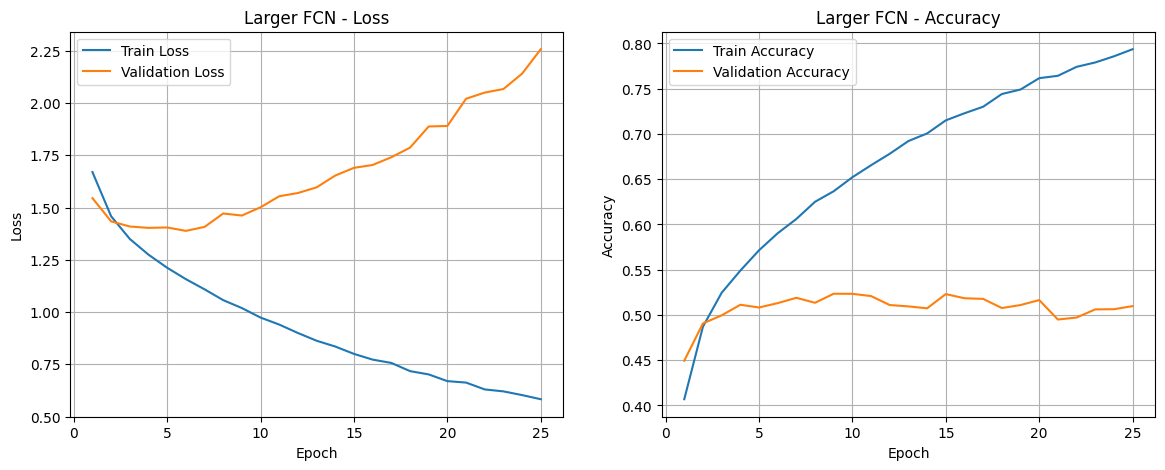

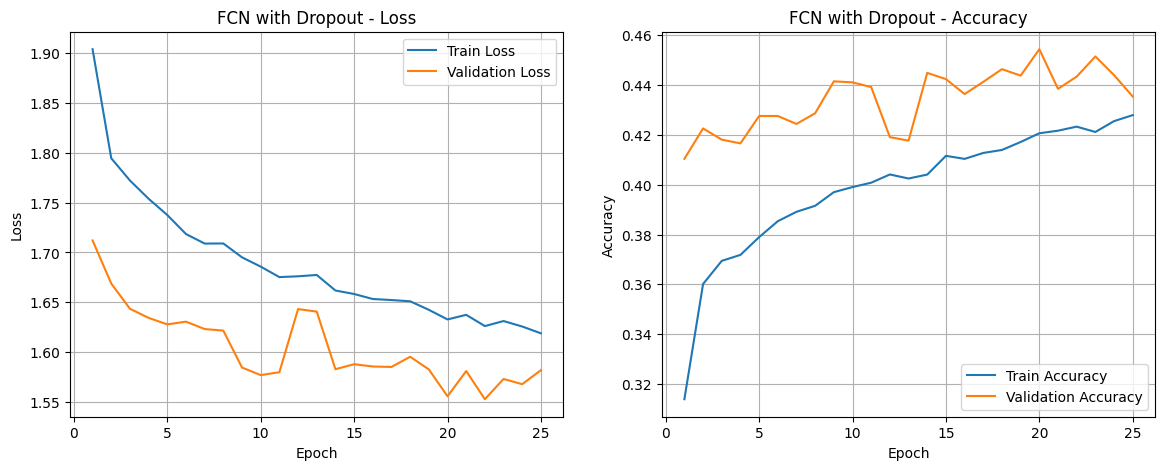

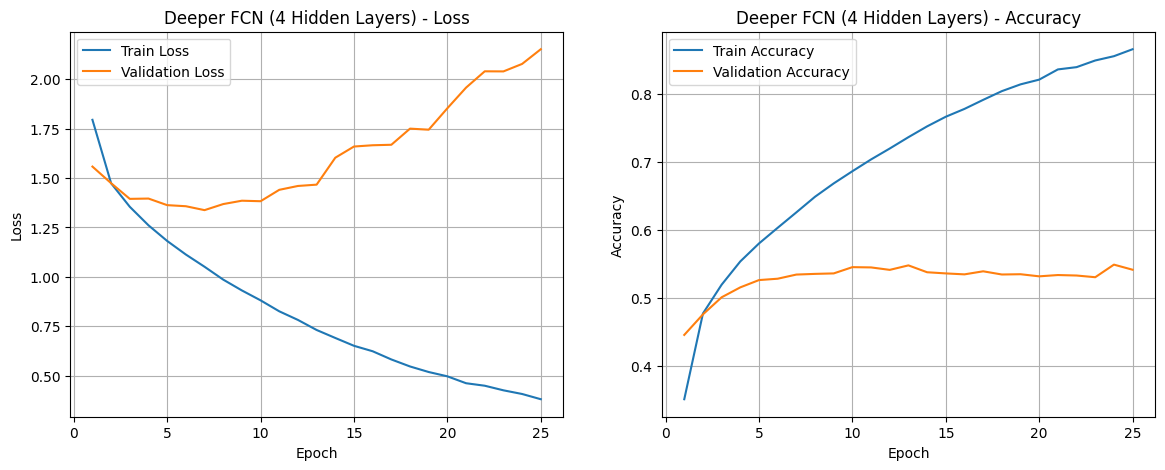

In [17]:
plot_history(history_large, title_prefix="Larger FCN")
plot_history(history_dropout, title_prefix="FCN with Dropout")
plot_history(history_deeper, title_prefix="Deeper FCN (4 Hidden Layers)")


Both the larger FCN and the deeper FCN showed significantly higher training accuracy (up to 86%), confirming that the models are capable of memorizing the training set.
However, the best validation accuracy across all FCNs saturated around 53–54%, only slightly higher than the baseline.
The dropout variant consistently produced:
* the worst training accuracy (~40%)
* the worst validation accuracy (~44–45%)


The deeper FCN reached:
* ~86% training accuracy
* up to ~54% validation accuracy
but:
* validation loss increases steadily
* accuracy plateaus early
* the model overfits rapidly
* generalization remains weak

This confirms that depth alone does not compensate for the lack of convolutional structure.
The other thing to look at would be architecture, let's try one more time to get more advanced MLP training tricks could help FCNs generalize better. Maybe optimization improvements can compensate for the lack of spatial inductive bias.

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x + residual
        

class BestFCN(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=512, depth=4, num_classes=10):
        super().__init__()
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim)
        )

        self.blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(depth)]
        )

        self.output_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.output_head(x)


Epoch 1/25 | Train Loss: 1.5878 Acc: 0.431 | Test Loss: 1.4466 Acc: 0.481
Epoch 2/25 | Train Loss: 1.3548 Acc: 0.515 | Test Loss: 1.3613 Acc: 0.519
Epoch 3/25 | Train Loss: 1.2231 Acc: 0.566 | Test Loss: 1.3812 Acc: 0.514
Epoch 4/25 | Train Loss: 1.1138 Acc: 0.603 | Test Loss: 1.3329 Acc: 0.539
Epoch 5/25 | Train Loss: 1.0101 Acc: 0.638 | Test Loss: 1.3550 Acc: 0.535
Epoch 6/25 | Train Loss: 0.9052 Acc: 0.674 | Test Loss: 1.3648 Acc: 0.538
Epoch 7/25 | Train Loss: 0.8045 Acc: 0.713 | Test Loss: 1.4240 Acc: 0.541
Epoch 8/25 | Train Loss: 0.6943 Acc: 0.753 | Test Loss: 1.4762 Acc: 0.544
Epoch 9/25 | Train Loss: 0.6000 Acc: 0.786 | Test Loss: 1.5355 Acc: 0.548
Epoch 10/25 | Train Loss: 0.5037 Acc: 0.821 | Test Loss: 1.7148 Acc: 0.536
Epoch 11/25 | Train Loss: 0.4257 Acc: 0.849 | Test Loss: 1.7565 Acc: 0.551
Epoch 12/25 | Train Loss: 0.3469 Acc: 0.876 | Test Loss: 1.9326 Acc: 0.542
Epoch 13/25 | Train Loss: 0.2955 Acc: 0.895 | Test Loss: 2.0747 Acc: 0.542
Epoch 14/25 | Train Loss: 0.2423 A

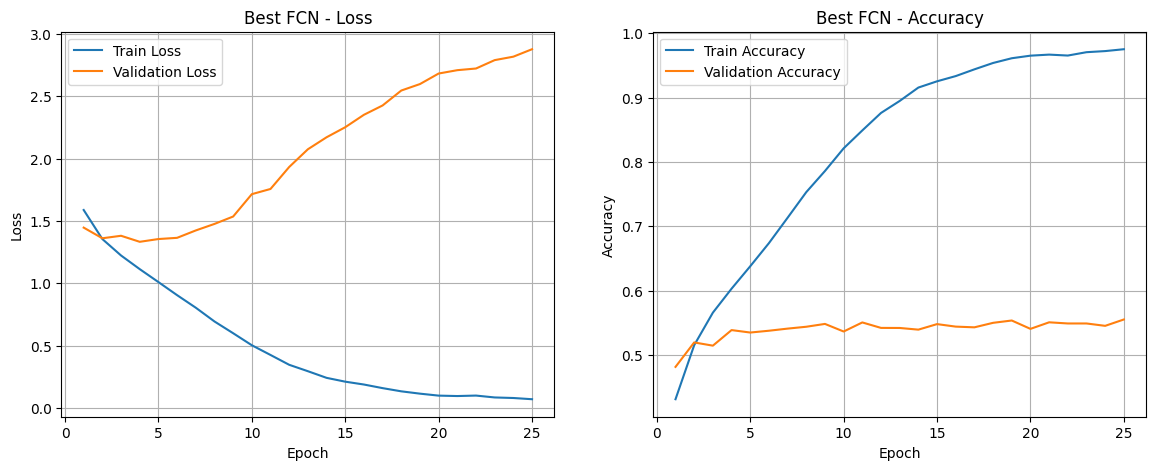

In [29]:
model_best = BestFCN().to(device)
optimizer_best = optim.SGD(model_best.parameters(), lr=0.01, momentum=0.9)
history_best = train_model(model_best, optimizer_best, criterion, train_loader, test_loader, device=device
)
plot_history(history_best, title_prefix="Best FCN")


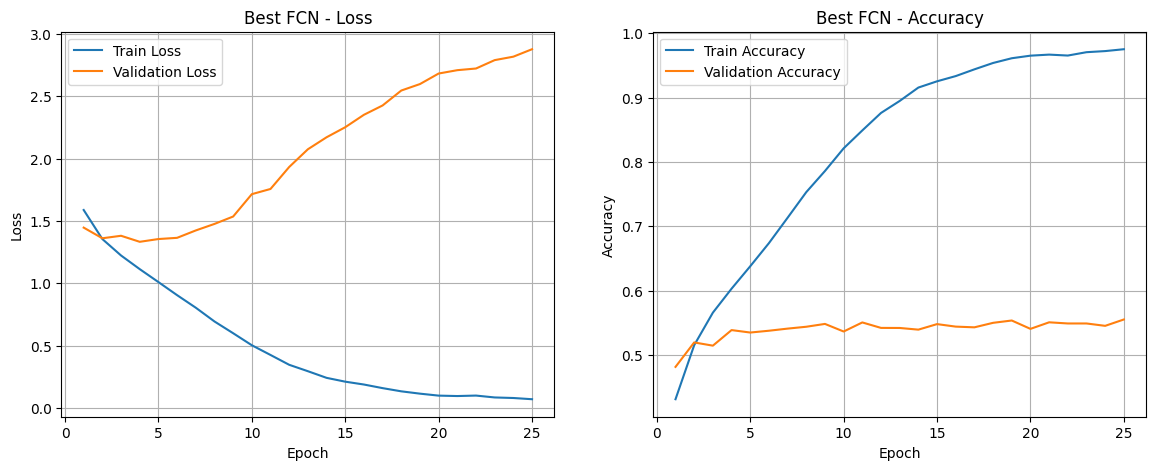

In [30]:
plot_history(history_best, title_prefix="Best FCN")


Even advanced MLP architectures plateau at ~55%.
This confirms that the limitation is architectural, not optimization-related.

### Hyperparameter Tuning

Before concluding the FCN part of this project, we perform a small hyperparameter tuning study to understand how different settings affect performance.
Fully connected networks are not ideal for image classification, but tuning helps us separate:
* what the FCN can do with the right settings
* what its inherent limitations are

We explore three important hyperparameters:
* Learning rate — affects convergence speed and stability
* Batch size — affects gradient noise and generalization
* Hidden layer size — affects model capacity

The goal is not to find perfect values, but to document which settings help and which do not, and to choose a reasonable “best” FCN model for comparison in Part 2.

In [23]:
def quick_train(model_class, lr, batch_size, hidden1=None, hidden2=None, 
                epochs=5, device='cpu'):
    """
    Train a small model for quick hyperparameter testing.
    Returns final validation accuracy.
    """
    
    # Update DataLoader if batch size changes
    train_loader_local = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader_local  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # Instantiate model
    if hidden1 is not None and hidden2 is not None:
        model = model_class(hidden1=hidden1, hidden2=hidden2).to(device)
    else:
        model = model_class().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    history = train_model(
        model, optimizer, criterion,
        train_loader_local, test_loader_local,
        epochs=epochs, device=device
    )

    return history["test_acc"][-1]  # final validation accuracy


#### Learning rate

In [24]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
lr_results = {}

for lr in learning_rates:
    print(f"\nTesting lr={lr}")
    acc = quick_train(FCN, lr=lr, batch_size=64, epochs=5, device=device)
    lr_results[lr] = acc



Testing lr=0.1
Epoch 1/5 | Train Loss: 2.2822 Acc: 0.120 | Test Loss: 2.3110 Acc: 0.100
Epoch 2/5 | Train Loss: 2.3059 Acc: 0.101 | Test Loss: 2.3055 Acc: 0.100
Epoch 3/5 | Train Loss: 2.3068 Acc: 0.101 | Test Loss: 2.3121 Acc: 0.100
Epoch 4/5 | Train Loss: 2.3057 Acc: 0.101 | Test Loss: 2.3061 Acc: 0.100
Epoch 5/5 | Train Loss: 2.3051 Acc: 0.102 | Test Loss: 2.3052 Acc: 0.100

Testing lr=0.05
Epoch 1/5 | Train Loss: 1.9993 Acc: 0.268 | Test Loss: 1.9968 Acc: 0.258
Epoch 2/5 | Train Loss: 1.9991 Acc: 0.267 | Test Loss: 1.9839 Acc: 0.255
Epoch 3/5 | Train Loss: 1.9628 Acc: 0.278 | Test Loss: 1.9798 Acc: 0.312
Epoch 4/5 | Train Loss: 1.9608 Acc: 0.271 | Test Loss: 1.9692 Acc: 0.295
Epoch 5/5 | Train Loss: 1.9332 Acc: 0.282 | Test Loss: 1.9693 Acc: 0.281

Testing lr=0.01
Epoch 1/5 | Train Loss: 1.7141 Acc: 0.389 | Test Loss: 1.6173 Acc: 0.425
Epoch 2/5 | Train Loss: 1.5121 Acc: 0.466 | Test Loss: 1.5239 Acc: 0.468
Epoch 3/5 | Train Loss: 1.4334 Acc: 0.495 | Test Loss: 1.4409 Acc: 0.494
E

#### Batch size

In [25]:
batch_sizes = [32, 64, 128, 256]
bs_results = {}

for bs in batch_sizes:
    print(f"\nTesting batch size={bs}")
    acc = quick_train(FCN, lr=0.01, batch_size=bs, epochs=5, device=device)
    bs_results[bs] = acc



Testing batch size=32
Epoch 1/5 | Train Loss: 1.7479 Acc: 0.377 | Test Loss: 1.5943 Acc: 0.434
Epoch 2/5 | Train Loss: 1.5919 Acc: 0.438 | Test Loss: 1.5933 Acc: 0.434
Epoch 3/5 | Train Loss: 1.5343 Acc: 0.464 | Test Loss: 1.5487 Acc: 0.463
Epoch 4/5 | Train Loss: 1.4910 Acc: 0.479 | Test Loss: 1.5293 Acc: 0.474
Epoch 5/5 | Train Loss: 1.4613 Acc: 0.491 | Test Loss: 1.5374 Acc: 0.466

Testing batch size=64
Epoch 1/5 | Train Loss: 1.7009 Acc: 0.395 | Test Loss: 1.5619 Acc: 0.454
Epoch 2/5 | Train Loss: 1.5079 Acc: 0.466 | Test Loss: 1.4672 Acc: 0.482
Epoch 3/5 | Train Loss: 1.4308 Acc: 0.494 | Test Loss: 1.4616 Acc: 0.482
Epoch 4/5 | Train Loss: 1.3751 Acc: 0.512 | Test Loss: 1.4368 Acc: 0.499
Epoch 5/5 | Train Loss: 1.3369 Acc: 0.528 | Test Loss: 1.4591 Acc: 0.485

Testing batch size=128
Epoch 1/5 | Train Loss: 1.7450 Acc: 0.378 | Test Loss: 1.5576 Acc: 0.447
Epoch 2/5 | Train Loss: 1.5107 Acc: 0.468 | Test Loss: 1.4913 Acc: 0.469
Epoch 3/5 | Train Loss: 1.4179 Acc: 0.501 | Test Loss:

#### Hidden Size

In [27]:
hidden_variants = [
    (100, 20),
    (256, 128),
    (512, 256)
]

hidden_results = {}

for h1, h2 in hidden_variants:
    print(f"\nTesting hidden sizes = ({h1}, {h2})")
    acc = quick_train(FCN, lr=0.01, batch_size=64, 
                      hidden1=h1, hidden2=h2,
                      epochs=5, device=device)
    hidden_results[(h1, h2)] = acc



Testing hidden sizes = (100, 20)
Epoch 1/5 | Train Loss: 1.7293 Acc: 0.382 | Test Loss: 1.5971 Acc: 0.433
Epoch 2/5 | Train Loss: 1.5247 Acc: 0.461 | Test Loss: 1.4980 Acc: 0.471
Epoch 3/5 | Train Loss: 1.4358 Acc: 0.493 | Test Loss: 1.4780 Acc: 0.477
Epoch 4/5 | Train Loss: 1.3810 Acc: 0.511 | Test Loss: 1.4512 Acc: 0.477
Epoch 5/5 | Train Loss: 1.3409 Acc: 0.524 | Test Loss: 1.4356 Acc: 0.489

Testing hidden sizes = (256, 128)
Epoch 1/5 | Train Loss: 1.6691 Acc: 0.407 | Test Loss: 1.5252 Acc: 0.455
Epoch 2/5 | Train Loss: 1.4458 Acc: 0.488 | Test Loss: 1.4291 Acc: 0.493
Epoch 3/5 | Train Loss: 1.3460 Acc: 0.526 | Test Loss: 1.3922 Acc: 0.507
Epoch 4/5 | Train Loss: 1.2744 Acc: 0.549 | Test Loss: 1.4110 Acc: 0.503
Epoch 5/5 | Train Loss: 1.2110 Acc: 0.570 | Test Loss: 1.3821 Acc: 0.520

Testing hidden sizes = (512, 256)
Epoch 1/5 | Train Loss: 1.6532 Acc: 0.414 | Test Loss: 1.4882 Acc: 0.474
Epoch 2/5 | Train Loss: 1.4270 Acc: 0.497 | Test Loss: 1.4343 Acc: 0.493
Epoch 3/5 | Train Lo

#### Conclusion
we will be using
* Learning rate: 0.005
* Batch size: 256
* Hidden sizes: (512, 256)

when we look at result, we see that training stability matters more than raw speed -> very high learning rates collapse quickly.
Increasing hidden sizes from (100, 20) → (512, 256) raises accuracy by only ~3–4%.
Generalization remains fundamentally capped.
Even the best FCN configuration plateaus around 52–53% accuracy.
=> This strongly suggests an architectural limitation.
FCNs cannot capture spatial structure in images because:
* flattening destroys locality
* all pixels become independent features
* no shared weights or receptive fields
* training becomes memorization rather than feature learning
* Never the less, we'll implement final model with these parameters

### Final model

We use CrossEntropyLoss because CIFAR-10 is a multi-class classification problem and the model outputs logits. SGD with momentum is chosen as the baseline optimizer because it provides stable convergence, good generalization, and serves as the standard benchmark for comparing different architectures. We're not going to try other optimizers and we're going to use FCN_Deeper as example of basic FCN without modern architecture, but we'll finetune the layers as the 1st 2

In [40]:
class FCN_Deeper_UPD(nn.Module):
    def __init__(self, input_dim=3072, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


train_loader_local = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader_local  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

final_fcn = FCN_Deeper_UPD().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_fcn.parameters(), lr=0.005, momentum=0.9)

history_final = train_model(
        final_fcn, optimizer, criterion,
        train_loader_local, test_loader_local,
        epochs=25, device=device
    )


Epoch 1/25 | Train Loss: 2.2375 Acc: 0.170 | Test Loss: 2.0532 Acc: 0.263
Epoch 2/25 | Train Loss: 1.8968 Acc: 0.304 | Test Loss: 1.7745 Acc: 0.360
Epoch 3/25 | Train Loss: 1.7010 Acc: 0.388 | Test Loss: 1.6096 Acc: 0.423
Epoch 4/25 | Train Loss: 1.5655 Acc: 0.437 | Test Loss: 1.5219 Acc: 0.458
Epoch 5/25 | Train Loss: 1.4670 Acc: 0.474 | Test Loss: 1.4681 Acc: 0.482
Epoch 6/25 | Train Loss: 1.3855 Acc: 0.507 | Test Loss: 1.4318 Acc: 0.495
Epoch 7/25 | Train Loss: 1.3197 Acc: 0.530 | Test Loss: 1.3989 Acc: 0.503
Epoch 8/25 | Train Loss: 1.2631 Acc: 0.552 | Test Loss: 1.3750 Acc: 0.520
Epoch 9/25 | Train Loss: 1.2084 Acc: 0.571 | Test Loss: 1.4225 Acc: 0.503
Epoch 10/25 | Train Loss: 1.1535 Acc: 0.591 | Test Loss: 1.3365 Acc: 0.531
Epoch 11/25 | Train Loss: 1.1025 Acc: 0.608 | Test Loss: 1.3962 Acc: 0.523
Epoch 12/25 | Train Loss: 1.0594 Acc: 0.623 | Test Loss: 1.3998 Acc: 0.519
Epoch 13/25 | Train Loss: 1.0126 Acc: 0.641 | Test Loss: 1.3562 Acc: 0.536
Epoch 14/25 | Train Loss: 0.9708 A

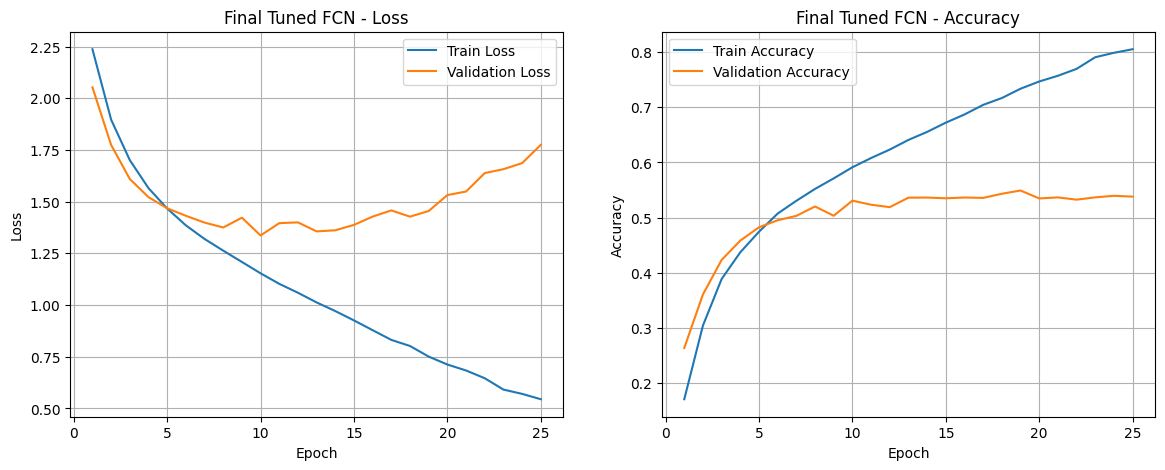

In [41]:
plot_history(history_final, title_prefix="Final Tuned FCN")


Using the best hyperparameters from tuning (lr=0.005, batch_size=256) and the updated deeper architecture (512 → 256 → 128 → 64 → 10), we trained the final fully connected model for 25 epochs. The results show a clear learning pattern:
* Training accuracy: increased steadily from 17% → 80.5%
* Validation accuracy: peaked around 53–54%
* Validation loss: initially improved but began rising after ~epoch 10

Key Observations

* The model successfully learns from the training set. It reaches over 80% train accuracy, showing that the architecture has enough capacity to fit the data.
*  Validation accuracy plateaus early (~53–54%). After epoch ~10, improvements in training accuracy do not translate to better validation performance.This indicates the model is learning dataset-specific correlations but failing to generalize to new data.


Even with:
* tuned learning rate
* tuned batch size
* increased capacity
* deeper structure
  
the FCN cannot surpass ~54% validation accuracy.

## Convolutional Neural Network (CNN)

Up to this point, we worked with fully connected networks (FCNs) and established a clear limitation:
once an image is flattened into a 3072-dimensional vector, the model loses all spatial structure.
As a result, FCNs cannot meaningfully interpret shifts, flips, edges, textures, or local patterns.

Now we transition to Convolutional Neural Networks, which are specifically designed to handle images.
Unlike FCNs, CNNs learn from spatial relationships using local receptive fields and shared filters.
Because CNNs are spatially aware, we can finally make use of data augmentation (random crops, flips, padding) to improve generalization — augmentation that would not make sense for FCNs.

This part of the project builds a CNN classifier for CIFAR-10 and demonstrates how convolution dramatically improves both performance and robustness.

In [44]:
transform_train = transforms.Compose(
    [transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])
transform_val = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_stack = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_stack(x)
        return x


In [53]:
model = CNN().to(device)
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 512]       1,049,088
      BatchNorm1d-14                  [

In [61]:
num_epochs = 25
optimizer_ft = optim.SGD(model.parameters(), lr=0.018, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=0)
history_cnn = train_model(model, optimizer_ft, criterion, train_loader, test_loader, device=device, scheduler=scheduler
)

Epoch 1/25 | Train Loss: 1.4231 Acc: 0.485 | Test Loss: 1.0545 Acc: 0.627
Epoch 2/25 | Train Loss: 1.0827 Acc: 0.618 | Test Loss: 0.8958 Acc: 0.688
Epoch 3/25 | Train Loss: 0.9448 Acc: 0.667 | Test Loss: 0.7872 Acc: 0.727
Epoch 4/25 | Train Loss: 0.8571 Acc: 0.702 | Test Loss: 0.7108 Acc: 0.755
Epoch 5/25 | Train Loss: 0.7882 Acc: 0.726 | Test Loss: 0.7019 Acc: 0.757
Epoch 6/25 | Train Loss: 0.7194 Acc: 0.750 | Test Loss: 0.6612 Acc: 0.775
Epoch 7/25 | Train Loss: 0.6608 Acc: 0.771 | Test Loss: 0.6207 Acc: 0.789
Epoch 8/25 | Train Loss: 0.6133 Acc: 0.788 | Test Loss: 0.6325 Acc: 0.780
Epoch 9/25 | Train Loss: 0.5631 Acc: 0.804 | Test Loss: 0.6170 Acc: 0.786
Epoch 10/25 | Train Loss: 0.5141 Acc: 0.823 | Test Loss: 0.5947 Acc: 0.797
Epoch 11/25 | Train Loss: 0.4665 Acc: 0.838 | Test Loss: 0.5814 Acc: 0.804
Epoch 12/25 | Train Loss: 0.4263 Acc: 0.853 | Test Loss: 0.5703 Acc: 0.809
Epoch 13/25 | Train Loss: 0.3907 Acc: 0.864 | Test Loss: 0.5701 Acc: 0.812
Epoch 14/25 | Train Loss: 0.3674 A

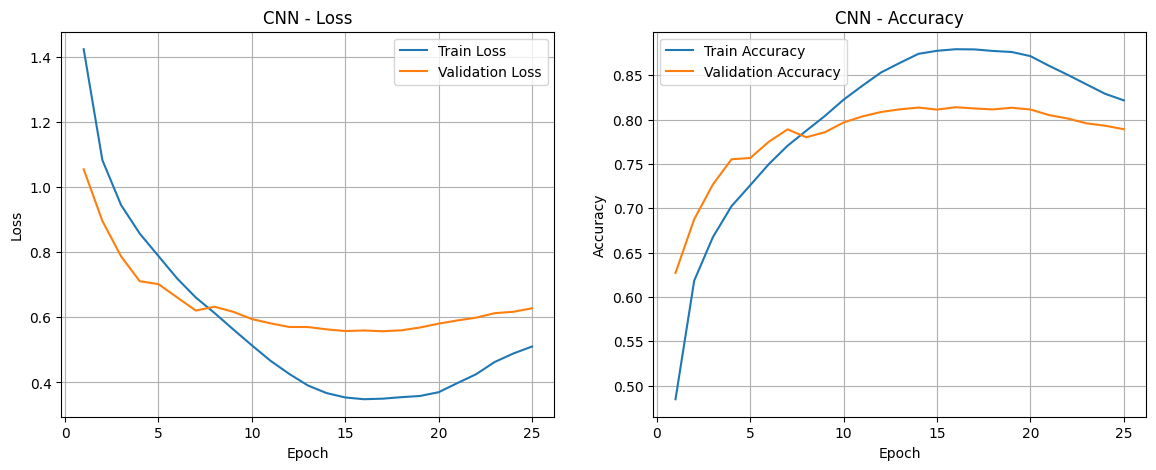

In [63]:
plot_history(history_cnn, title_prefix="CNN")

we see a clear and strong improvement compared to all FCN variants:
* Validation accuracy jumps from ~53% → ~81%
* Training converges quickly and smoothly
* Augmentation + convolution already gives a huge performance boost

However, starting around epoch 10–12, the model begins to overfit:
* Train accuracy keeps climbing toward 99%
* Test accuracy plateaus at ~81–82%
* Test loss begins increasing from epoch 15 onward
* Late-epoch collapse appears

So let's try to fight the late-epoch overfitting with more Dropuot

In [59]:
class CNN_StrongerDropout(nn.Module):
    def __init__(self):
        super(CNN_StrongerDropout, self).__init__()

        self.conv_stack = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),   

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),   
        )

        self.fc_stack = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),        

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),        

            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_stack(x)
        return x


In [60]:
model = CNN_StrongerDropout().to(device)
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
        Dropout2d-14            [-1, 12

Epoch 1/25 | Train Loss: 0.5838 Acc: 0.798 | Test Loss: 0.6506 Acc: 0.777
Epoch 2/25 | Train Loss: 0.5601 Acc: 0.807 | Test Loss: 0.6373 Acc: 0.782
Epoch 3/25 | Train Loss: 0.5333 Acc: 0.815 | Test Loss: 0.6302 Acc: 0.785
Epoch 4/25 | Train Loss: 0.5040 Acc: 0.826 | Test Loss: 0.6101 Acc: 0.792
Epoch 5/25 | Train Loss: 0.4754 Acc: 0.835 | Test Loss: 0.6273 Acc: 0.789
Epoch 6/25 | Train Loss: 0.4444 Acc: 0.847 | Test Loss: 0.5971 Acc: 0.797
Epoch 7/25 | Train Loss: 0.4094 Acc: 0.858 | Test Loss: 0.5890 Acc: 0.805
Epoch 8/25 | Train Loss: 0.3681 Acc: 0.871 | Test Loss: 0.5953 Acc: 0.804
Epoch 9/25 | Train Loss: 0.3268 Acc: 0.887 | Test Loss: 0.6036 Acc: 0.803
Epoch 10/25 | Train Loss: 0.2930 Acc: 0.898 | Test Loss: 0.5816 Acc: 0.813
Epoch 11/25 | Train Loss: 0.2559 Acc: 0.913 | Test Loss: 0.6015 Acc: 0.812
Epoch 12/25 | Train Loss: 0.2247 Acc: 0.924 | Test Loss: 0.5856 Acc: 0.819
Epoch 13/25 | Train Loss: 0.1999 Acc: 0.932 | Test Loss: 0.5778 Acc: 0.822
Epoch 14/25 | Train Loss: 0.1822 A

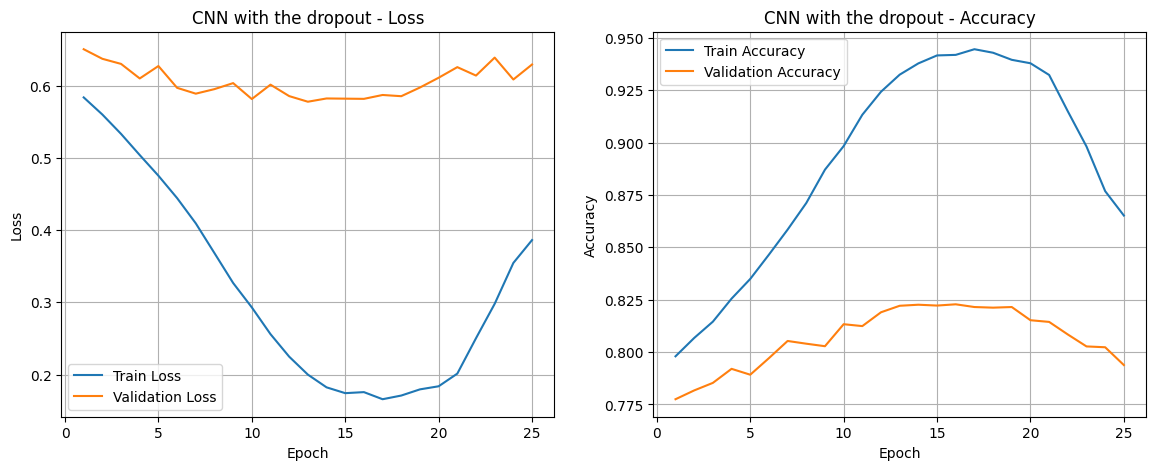

In [64]:
num_epochs = 25
optimizer_ft = optim.SGD(model.parameters(), lr=0.018, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=0)
history_cnn_dropout = train_model(model, optimizer_ft, criterion, train_loader, test_loader, device=device, scheduler=scheduler
)
plot_history(history_cnn_dropout, title_prefix="CNN with the dropout")

Updated architecture + regularization changes definitely improved the model:
* Test accuracy increased from ~81.0% → ~82.3%
* Train and test curves stay close together
* No overfitting spike — the gap remains small
* Loss curve smooth and consistent


## Final Project Conclusion
1. FCN Takeaways

Fully Connected Networks process images as arbitrary 1D vectors, ignoring spatial relationships between pixels. Even after:
* deepening the architecture
* adding dropout
* tuning learning rate, batch size, and hidden sizes

…the best FCN achieved only ~53–55% accuracy. FCNs also quickly overfit: train accuracy rises toward 90%+, while validation accuracy saturates early. This clearly demonstrates that FCNs are ill-suited for vision tasks, regardless of hyperparameter tuning.

**Conclusion: More layers and more neurons can memorize CIFAR-10, but they do not learn meaningful spatial patterns.**

2. CNN Takeaways

Switching to a CNN brings immediate improvements due to:
* local receptive fields
* weight sharing
* translation invariance
* batch normalization for stable optimization
* data augmentation to expand the effective training set

The custom CNN reaches ~82–83% validation accuracy, with training and validation curves closely aligned — no severe overfitting. Additional techniques (weight decay + CosineAnnealingLR) further improved generalization and training stability.

**Conclusion: CNNs extract hierarchical features (edges → textures → shapes → objects), which FCNs cannot.**